# ***Webscraping Led Zeppelin's Concert History with Selenium***

For scientific purposes only. 

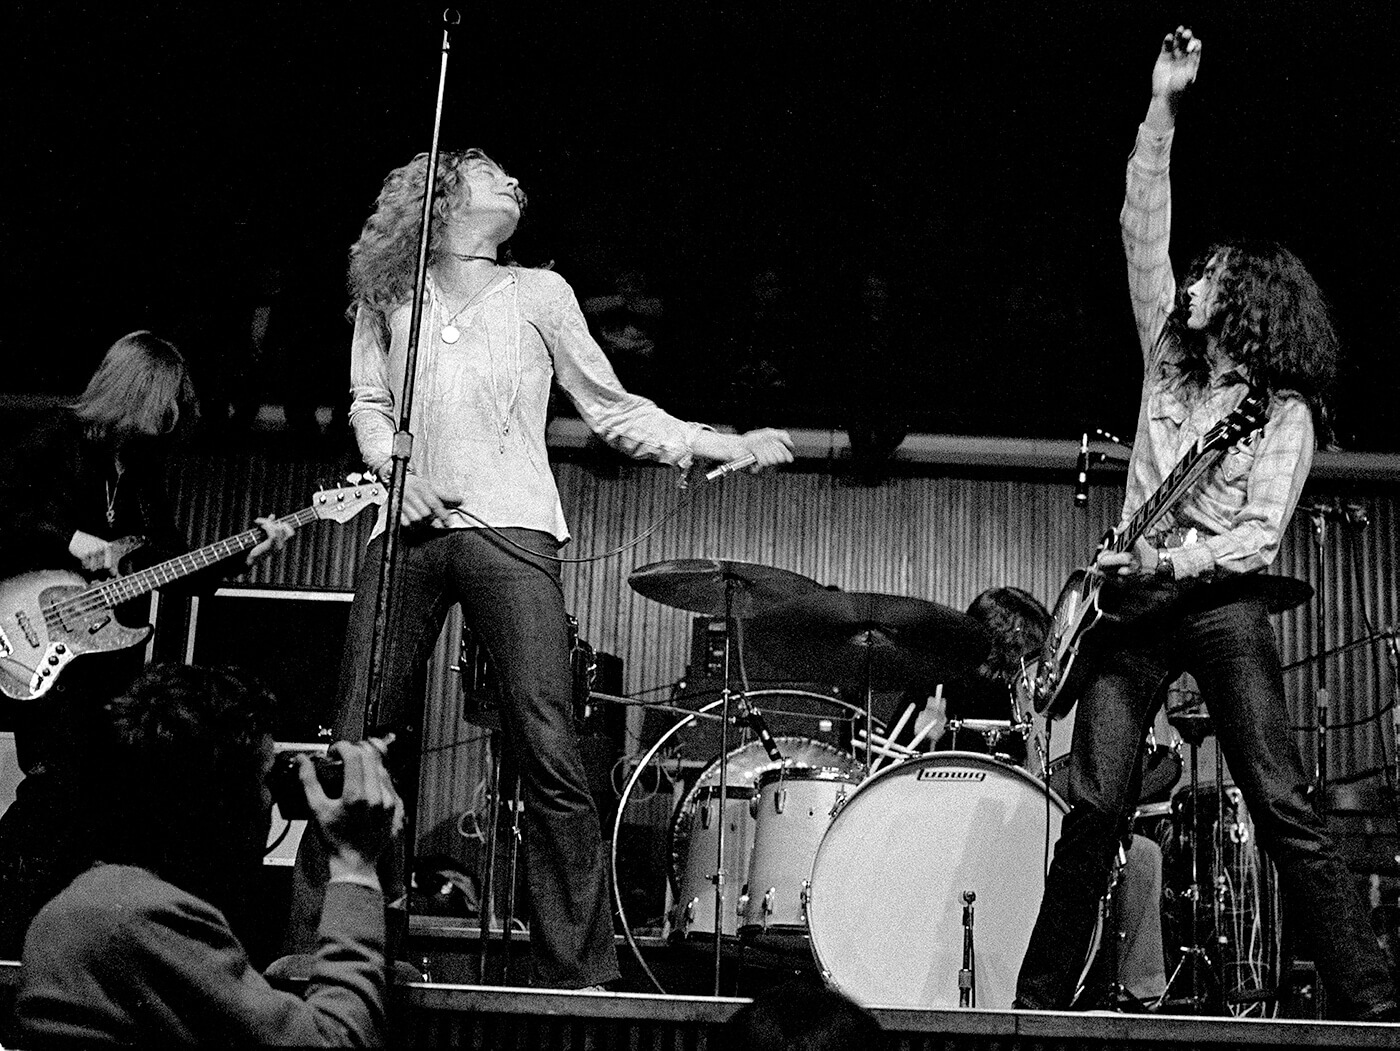

In [1]:
import time
import requests

from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from operator import itemgetter

import pandas as pd
import numpy as np

from datetime import date
from datetime import datetime
import geopandas
import matplotlib.pyplot as plt

In [2]:
def zep_scrap(url):
    url = url
    print(f"Getting concerts in: {url}")
    driver = webdriver.Chrome(r"C:\Users\Topcu\.wdm\drivers\chromedriver\win32\108.0.5359\chromedriver.exe")
    driver.get(url)
    #this particular site had a cookie so i'm clicking on it
    cookie = driver.find_element('xpath','//button[@id="onetrust-accept-btn-handler"]')
    try:
        cookie.click()
    except:
        pass
    #creating empty lists to store content
    dates = []
    venues =[]
    entry_items_list = driver.find_elements('xpath', '/html/body/div[1]/div/div/div[2]/div/div[1]/div/main/section/div/div[2]/div/div/div/div')[0]
    
    for i in entry_items_list.find_elements('xpath', "//span[@class='field-content']"): #dates xpath
        dates.append(i.text)
    for i in entry_items_list.find_elements('xpath', "//div[@class='field-content']"): #venues xpath
        venues.append(i.text)
    df = pd.DataFrame(columns = ["Date", "Venue"])
    dates = pd.Series(dates, name='Date')
    venues = pd.Series(venues, name='Venue')
    df = df.append(pd.concat([dates,venues], axis=1))

    return df

In [3]:
#the page i'm scraping data from had multiple pages in the form of url + "?page=" + page number 
def scrape(url):
    url = url + "?page="
    df = pd.DataFrame(columns = ["Date", "Venue"])
    i = 0
    while i<22:
        try:
            df = df.append(zep_scrap(url + str(i)))
            print(f"Page: {i+1}")
            i += 1
        except:
            break
    
    df = df.reset_index(drop=True)
    df.to_csv(r"C:\Users\Topcu\Desktop\zep-scrape\zep.csv")
    return df

In [ ]:
scrape("https://www.ledzeppelin.com/shows/all")

In [2]:
df = pd.read_csv(r"C:\Users\Topcu\Desktop\zep-scrape\zep.csv")
df.head()


,Unnamed: 0,Date,Venue
0,0,"September 7, 1968","Teen-Clubs, Box 45, Egegaard Skole"
1,1,"September 7, 1968","Brondby Pop-Club, Norregardsskolen"
2,2,"September 8, 1968",Reventlowparken
3,3,"September 8, 1968",Fjordvilla Club
4,4,"September 8, 1968",Teaterbygningen


In [4]:
df.shape

(425, 3)

In [3]:
#changing date column to datetime
df['Date'] = pd.to_datetime(df.Date)
df.head()

,Unnamed: 0,Date,Venue
0,0,1968-09-07,"Teen-Clubs, Box 45, Egegaard Skole"
1,1,1968-09-07,"Brondby Pop-Club, Norregardsskolen"
2,2,1968-09-08,Reventlowparken
3,3,1968-09-08,Fjordvilla Club
4,4,1968-09-08,Teaterbygningen


In [5]:
import geocoder
import requests

In [6]:
with requests.Session() as session:
    for address in df["Venue"]:
        coo = geocoder.osm(address, session=session)
        if coo:
            df.loc[df["Venue"] == address, "Long"] = round(coo.osm["x"], 2)
            df.loc[df["Venue"] == address, "Lat"] = round(coo.osm["y"], 2)

print(df)

     Unnamed: 0       Date                               Venue   Long    Lat
0             0 1968-09-07  Teen-Clubs, Box 45, Egegaard Skole    NaN    NaN
1             1 1968-09-07  Brondby Pop-Club, Norregardsskolen    NaN    NaN
2             2 1968-09-08                     Reventlowparken    NaN    NaN
3             3 1968-09-08                     Fjordvilla Club    NaN    NaN
4             4 1968-09-08                     Teaterbygningen  12.19  55.46
..          ...        ...                                 ...    ...    ...
420         420 1975-01-25                 Market Square Arena  -1.14  52.95
421         421 1975-01-29                       Coliseum (NC) -80.80  35.21
422         422 1975-01-31                     Olympia Stadium  66.97  39.67
423         423 1975-02-01            Civic Arena (Pittsburgh) -79.99  40.44
424         424 1975-02-03               Madison Square Garden -73.99  40.75

[425 rows x 5 columns]


In [7]:
df.columns

Index(['Unnamed: 0', 'Date', 'Venue', 'Long', 'Lat'], dtype='object')

In [8]:
point = df.copy()
point.dropna(inplace=True)

In [9]:
#created points for each concert to map them 
gdf = geopandas.GeoDataFrame(point, geometry=geopandas.points_from_xy(point.Long, point.Lat))

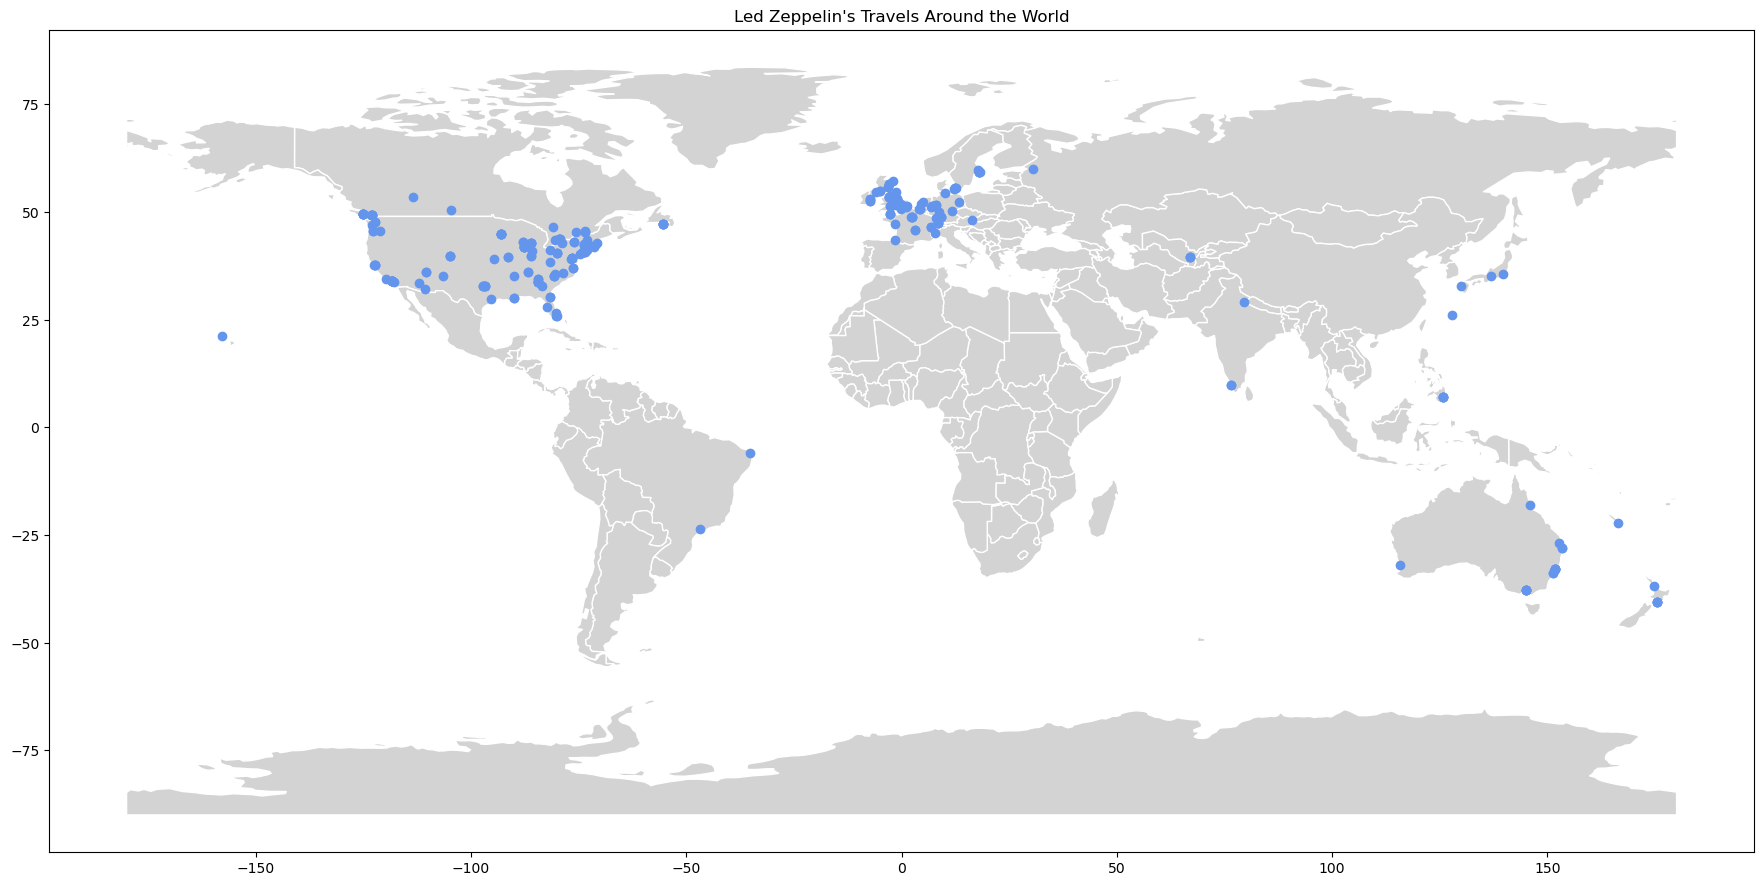

In [16]:
#wow!
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='lightgrey', edgecolor='white',figsize=(22,22))
# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='cornflowerblue')
plt.title("Led Zeppelin's Travels Around the World")
plt.show()